In [3]:
train = pd.read_csv("train.csv", sep = ",")
test = pd.read_csv("test.csv", sep = ",")

## Analysis Notebook

En este Notebook vamos a guiar un poco los pasos a seguir para entender cómo se comportan los datos. Empecemos añadiendo las librerías que vamos a usar. En el caso que saltase algún error, recordad que debéis instalarlas en el sistema con el comando: "pip install nombre_librería".

Recordad que para ejecutar el código que hay en cada celda, debéis pulsar CTRL+INTRO ó SHIFT+INTRO.

In [18]:
# Librerías para el análisis de datos:
import numpy as np 
import pandas as pd 

# y para la visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

La librería *pandas* nos permite trabajar con *dataframes*, que no es más que organizar los datos en forma de tabla. La sintaxis de *pandas as pd* es una manera de acortar el código, de manera que podremos acceder a las funciones propias de la librería como: pd.*funcion*

Empecemos cargando los datos con la función *read_csv* de esta misma librería. Aún así, hace falta saber qué parámetros debemos meterle a la función. Si ejecutáis el siguiente comando podréis leer toda la información necesaria acerca de la función.

In [ ]:
?pd.read_csv

Ahora ya conocemos los argumentos que requiere *read_csv*. Aún así es importante abrir los datos, por ejemplo con el Notepad, para ver dos aspectos importantes: 
1. Vienen las columnas con *header*?
2. Qué tipo de separador hay? (podrían ser espacios, comas, puntos y comas...)

In [ ]:
# train = ...
# test = ...

Dimensiones de los datos que hemos cargado?

In [4]:
train.shape

(891, 12)

Ahora ya podemos echar un ojo a los datos. Usamos, por ejemplo, el comando *sample*, que nos dará *n* filas aleatorias como muestra.

In [5]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C


Una parte importante de la visualización es poder determinar el tipo de los datos para saber qué gráficos nos pueden dar la máxima información en cada caso. Por ejemplo, veamos el procentaje de hombres/mujeres que sobrevivieron.

('Porcentaje de mujeres que sobrevivieron:', 74.203821656050948)
('Porcentaje de hombres que sobrevivieron:', 18.890814558058924)


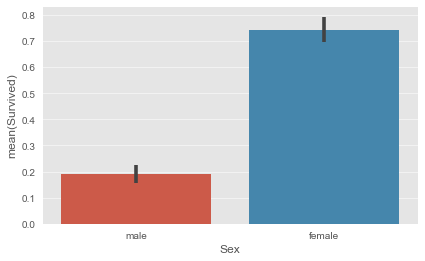

In [19]:
# barplot de la supervivencia dividida por sexo:
sns.barplot(x="Sex", y="Survived", data=train)

print("Porcentaje de mujeres que sobrevivieron:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Porcentaje de hombres que sobrevivieron:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

In [7]:
train.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

Cualquier análisis previo nos aporta información de qué esperar luego de nuestro modelo, así que si en el futuro predecimos que se salvan muchos más hombres que mujeres, tocará revisar el modelo!

También es importante fijarnos en los valores nulos, ya que pueden afectar negativamente nuestro modelo. Algunos de los más nuevos y potentes ya tienen mecanismos internos para trabajar con ellos, pero como norma general el trabajo humano acaba siendo más fiable.

In [8]:
print(pd.isnull(train.Age).sum())

177


Vemos como en la variable *Age* nos faltan 177 registros. No es un número demasiado grande, luego podemos intentar imputarles un valor nosotros que se ajuste al resto de valores de la muestra, como podría ser la media.

In [9]:
media_edad = np.mean(train["Age"])

for x in range(len(train["Age"])):
    if pd.isnull(train["Age"][x]):
        train["Age"][x] = media_edad

Si ahora vemos la distribución de la edad:

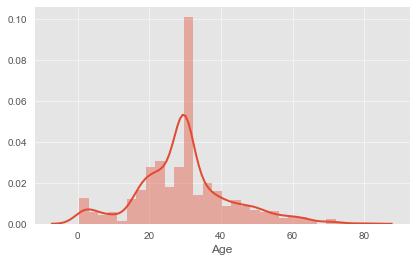

In [20]:
sns.distplot(train.Age)

Aún así, utilizar la media capaz no es la medida más adecuada, ya que al imputar los 177 valores a 29 años, la distribución se rompe. La edad puede verse afectada por otros factores: la media de edad de las mujeres casadas será, por lo general, más alta que de las no casadas, o una persona viajando en primera clase seguramente será mayor que alguien en tercera. Probad de analizar como está distribuída la edad usando información de otras columnas para imputarle un valor mejor y no desviar la muestra.

Por ejemplo, veamos como cambia la edad dentro de cada clase:

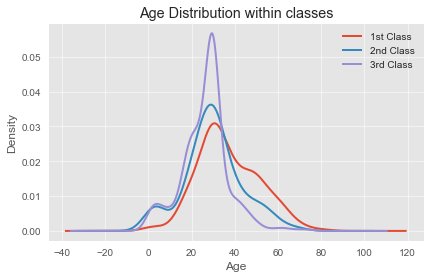

In [35]:
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

Afecta la edad sobre la supervivencia?

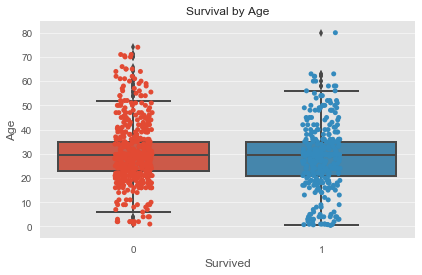

In [38]:
ax = sns.boxplot(x="Survived", y="Age", 
                data=train)
ax = sns.stripplot(x="Survived", y="Age",
                   data=train, jitter=True,
                   edgecolor="gray")
sns.plt.title("Survival by Age",fontsize=12);

Un tema interesante acerca de los nombres de la época es que en ellos se refleja el estatus social como prefijo: Mr, Col, Countess... y no es difícil pensar que se intentará salvar antes a la condesa que al conjunto de místers que pueda haber en el barco. Por ello es importante conocer bien los datos, para poder sacar información que no está explícita pero que resulta súmamente importante.

In [11]:
# Vamos a añadir la columna "Title" a ambos datasets, ya que no me sirve de nada usarla para entrenar el modelo
# si no la tengo a la hora de predecir.
combine = [train, test]

# Sabemos que el título de cada persona es un conjunto de letras delante de un punto:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Veamos, por ejemplo, la distribución de sexo/título
pd.crosstab(train['Title'], train['Sex'])

# idea: imputar la edad por título?

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Veamos la distribución de la clase del pasajero y el sexo:

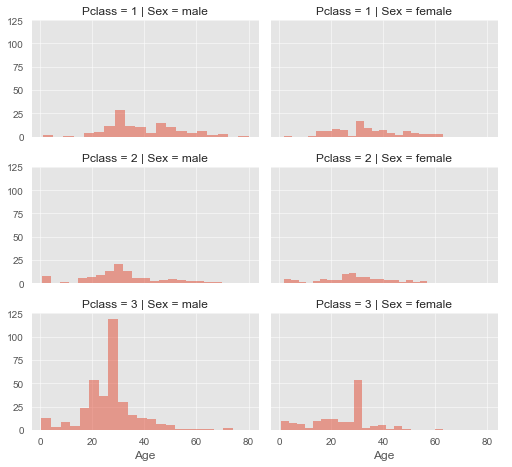

In [21]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Pasa algo con las escalas de estas dos variables? Sería interesante aplicar algun filtro?

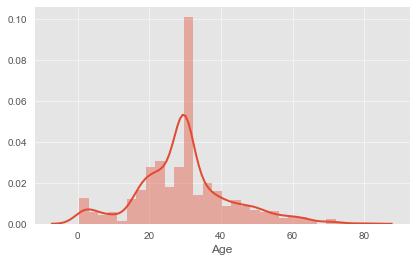

In [26]:
sns.distplot(train.Age)

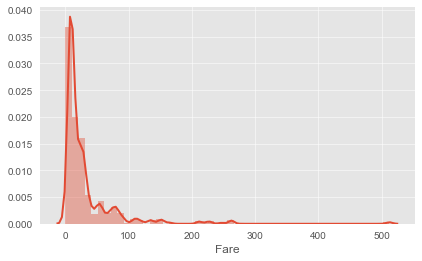

In [33]:
sns.distplot(train.Fare)

Ahora ya tenemos una primera visión de nuestros datos. Sabemos que debemos ver el número de valores faltantes en cada columna y tratar de imputarlos, si se cree conveniente, de la mejor manera posible. También hemos visto que hay información "oculta" que puede ser vital, si se sabe detectar y extraer. También hemos visto como sacar toda la información referente a las funciones de las librerías, y disponemos de **Stack Overflow** con respuestas a todas las preguntas a nivel de código.

A partir de aquí toca visualizar el resto de datos, cuál es su comportamiento respecto la variable objetivo para ver si hay un peso real (como en el caso del sexo) e intentar sacar conclusiones que esperaríamos comprobar en los resultados del modelo.

Ideas interesantes:

1. Es posible que haya variables muy correladas entre si? Lo que significa que tienen un comportamiento parecido. Sería posible eliminar alguna de las variables en el futuro modelo ya que su comportamiento está explicado por otra? Investigar la función pd.corr(), que nos devuelve la correlación y su visualización con sns.heatmap.

2. Sabemos que la edad es una variable continua. Qué resulta más útil: usar la edad tal y como nos viene, o agrupar los pasajeros en franjas? Podemos agrupar alguna otra variable?

3. Que se hayan limpiado los valores faltantes no significa que el resto de valores vayan a ser correctos, comprobar que los registros tienen sentido, sinó podría añadirse ruído al modelo.

4. Es posible que combinar algunas variables nos aporte más información que la variable por si sola? Por ejemplo, añadir una columna a los datos que nos indique si el pasajero viajaba solo o no.

5. Si creamos variables nuevas que tratan de explicar mejor ciertos aspectos de los datos, nos conviene para algo conservar las variables viejas?